<a href="https://colab.research.google.com/github/StevenJourney/Computer_Vision/blob/main/Transfer_learning_and_fine_tuning_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
tf.__version__

'2.17.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Computer Vision Masterclass/Datasets/homer_bart_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

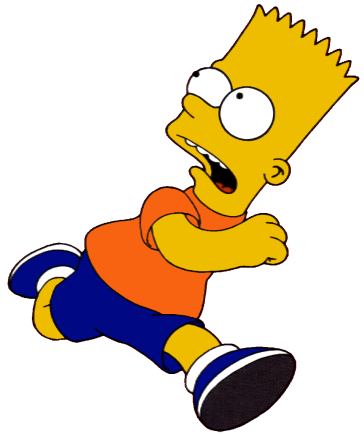

In [ ]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart100.bmp')

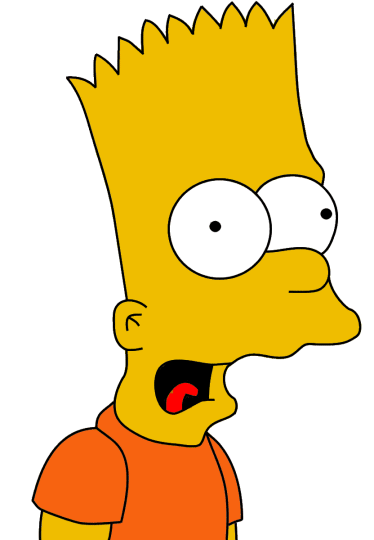

In [ ]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart112.bmp')

### Train and test set

In [ ]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/homer_bart_2/training_set',
                                                        target_size = (256, 256),
                                                        batch_size = 8,
                                                        class_mode = 'categorical',
                                                       shuffle = True)

Found 215 images belonging to 2 classes.


In [ ]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/homer_bart_2/test_set',
                                                     target_size = (256, 256),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 54 images belonging to 2 classes.


### Pre-trained network

ResNet: https://arxiv.org/pdf/1512.03385.pdf

Documentation: https://keras.io/api/applications/


In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                            input_tensor = Input(shape = (256, 256, 3))) #include_top = False because we don't want to dense part of architecture

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
len(base_model.layers)

175

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True> F

### Customer dene layer

In [ ]:
base_model.output

<KerasTensor shape=(None, 8, 8, 2048), dtype=float32, sparse=False, name=keras_tensor_174>

In [ ]:
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

### Building and training the neural network

In [ ]:
base_model.input

[<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=None, name=keras_tensor>]

In [ ]:
network = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
network.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,741,639 (102.01 MB)

 Trainable params: 3,153,927 (12.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
network.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = network.fit(train_dataset, epochs = 50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 361ms/step - accuracy: 0.5828 - loss: 1.2028
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.5268 - loss: 0.7609
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6040 - loss: 0.6476
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.6621 - loss: 0.6843
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.5936 - loss: 0.6618
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.6164 - loss: 0.6340
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6963 - loss: 0.5815
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.6159 - loss: 0.6280
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.7569 - loss: 0.5995
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.6488 - loss: 0.6070
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.7235 - loss: 0.5636
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accurac

### Evaluation the nueral Network

In [ ]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
predictions = network.predict(test_dataset)
predictions = np.argmax(predictions,axis=1)
predictions


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
#Approach 1 (all pixels): 0.68
#Approach 2 (feature) :0.88
# Approach 3 (CNN) :0.92
# Approach 4 (Transfer learning): 0.81

from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes,predictions)

0.8518518518518519

<Axes: >

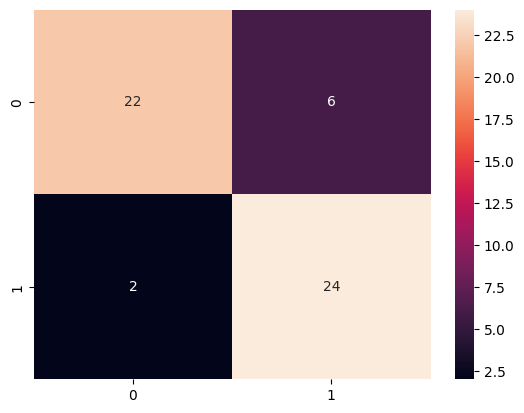

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        28
           1       0.80      0.92      0.86        26

    accuracy                           0.85        54
   macro avg       0.86      0.85      0.85        54
weighted avg       0.86      0.85      0.85        54



### Fine tuning

In [ ]:
base_model.trainable = True

In [ ]:
for layer in base_model.layers:
  print(layer)

<InputLayer name=input_layer, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Activa

In [ ]:
len(base_model.layers)

175

In [ ]:
fine_tuning_at = 140

In [ ]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 303ms/step - accuracy: 0.8065 - loss: 0.4269
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8285 - loss: 0.3873
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.8851 - loss: 0.3193
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.8075 - loss: 0.3953
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.8363 - loss: 0.3916
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.8619 - loss: 0.3412
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8717 - loss: 0.2781
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.7951 - loss: 0.3883
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.9168 - loss: 0.2597
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.8768 - loss: 0.2713
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.8417 - loss: 0.3252
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/st

In [ ]:
predictions = network.predict(test_dataset)

54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step


In [ ]:
predictions = np.argmax(predictions,axis=1)

In [ ]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1])

In [ ]:
accuracy_score(predictions, test_dataset.classes)

0.8148148148148148

In [ ]:
from tensorflow.keras.models import save_model, load_model

save_model(network, "steven_model.keras")

In [ ]:
steven_model = load_model("/content/steven_model.keras")

In [ ]:
image = cv2.imread('/content/homer_bart_2/test_set/bart/bart21.bmp')
image = cv2.resize(image,(256,256))
image = image/255 #normalize
image = image.reshape(1,256,256,3) # Add batch dimension
result = network.predict(image)
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


array([[0.5080099 , 0.49199015]], dtype=float32)

In [ ]:
result=np.argmax(result)
result

0

In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.1 MB/s eta 0:00:00


In [ ]:
import gradio as gr

class_names = ['Bart', 'Homer']

def predict(input_img):
  input_img = tf.image.resize(input_img, [256, 256])
  input_img = input_img/255
  input_img = image.reshape(1,256,256,3)  # Add batch dimension
  pred = steven_model.predict(input_img)
  score = tf.nn.softmax(pred[0])
  return class_names[np.argmax(score)]

interface = gr.Interface(
  fn=predict,
  inputs=gr.Image(),
  outputs="text",
  title="Bart or Homer",
  description="Drop an image of Bart or Homer. The model will classify it."
)

interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7dcb7b71eabddfc798.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
